In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy.fftpack as scfft

plt.rcParams['figure.figsize'] = [8, 5]

In [3]:
def sinc_Helper(tap, length):
    t_sinc = np.linspace(-1,1,length)
    sinc = np.sinc(tap / 2 * t_sinc)
    return sinc

In [4]:
def PFB_Helper(tap, signal, fs):
    '''
    Arguments:
        tap: the number of taps of the PFB;
        signal: the signal that needs to be processed
        fs: the sampling rate of the signal (samples per second)
        
    Returns:
        FFT_sum: the real-DFT of the signal
        FFT_freq: the absolute frequency (in Hz), on the x-axis
    '''
    N = len(signal)
    if N % tap != 0: # cut the signal short if modulo is not zero
        signal = signal[:N - (N % tap)]
        N = N - (N % tap)
    t = np.arange(N) # x-axis in terms of frequency channels
    
    conv = sinc_Helper(tap, N)*signal # convolution step
    conv_list = []
    for i in range(tap):
        conv_list.append(np.array(conv[i*(N//tap):(i+1)*(N//tap)]))
    conv_array = np.array(conv_list)
    conv_sum = np.sum(conv_array, axis=0)
    
    FFT_sum = np.fft.rfft(conv_sum) # real-FFT step
    if fs != -1:
        FFT_freq = np.fft.rfftfreq(N//tap)*fs
    else:
        FFT_freq = None
    
    return FFT_sum, FFT_freq

In [5]:
def PFB(raw_signal, n_c, n_tap):
    output_matrix = []
    while len(raw_signal) > (2*n_c*n_tap):
        process_signal = raw_signal[:2*n_c*n_tap]
        FFT, freq = PFB_Helper(n_tap, process_signal, -1)
        FFT = list(FFT)
        output_matrix.append(FFT)
        raw_signal = raw_signal[2*n_c:]
    output_matrix = np.array(output_matrix)
    return output_matrix

In [23]:
def PFB_Inverse(signal, n_tap):
    data_step1 = np.fft.irfft(signal, axis=1)
    window = sinc_Helper(n_tap, n_tap*data_step1.shape[1])
    window = np.reshape(window, [n_tap, data_step1.shape[1]])
    matrix = np.zeros(data_step1.shape)
    matrix[:n_tap,:] = window
    data_DFT = np.fft.rfft(data_step1, axis=0) # Step 1: DFT
    matrix_DFT = np.fft.rfft(matrix, axis=0) # Step 2.1: DFT of first row of C_k
    inverted = np.fft.irfft(data_DFT/np.conj(matrix_DFT), axis=0) # Step 2.2 & 3: divide by conjugate, then IDFT
    return inverted.flatten()

In [16]:
N = np.arange(10e6)
t = N/2048
nu = 25.67 # frequency is configured here
sine = np.cos(2*np.pi*nu*t)

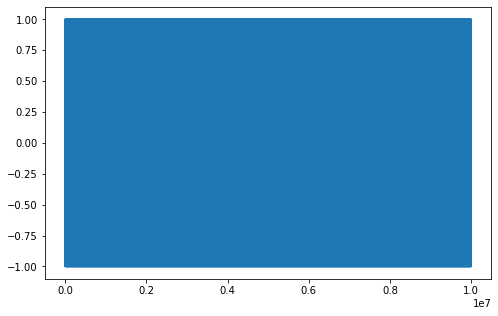

In [17]:
plt.plot(sine)

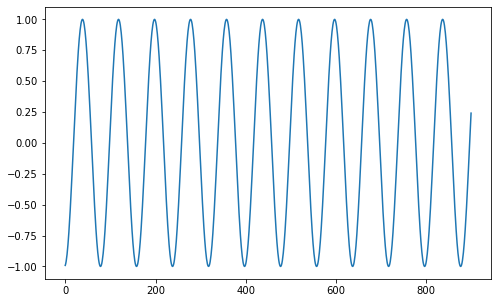

In [18]:
plt.plot(sine[600:1500])

In [19]:
Forward = PFB(sine, 512, 4)

In [20]:
Orginal = PFB_Inverse(Forward, 4)

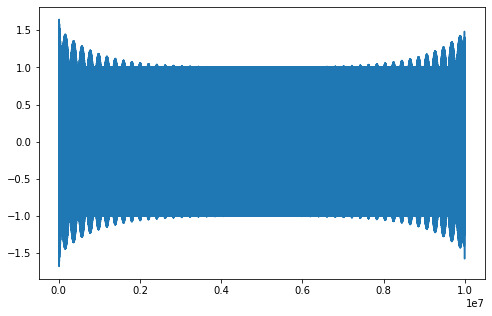

In [21]:
plt.plot(Orginal)

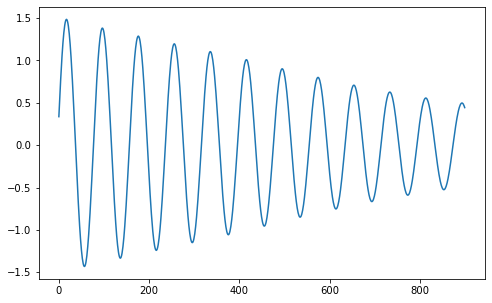

In [22]:
plt.plot(Orginal[600:1500])

In [58]:
N = np.arange(1048576)
t = N/2048
nu = 25.67 # frequency is configured here
sine = np.cos(2*np.pi*nu*t)

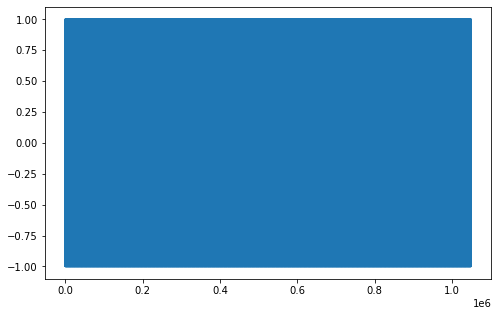

In [59]:
plt.plot(sine)

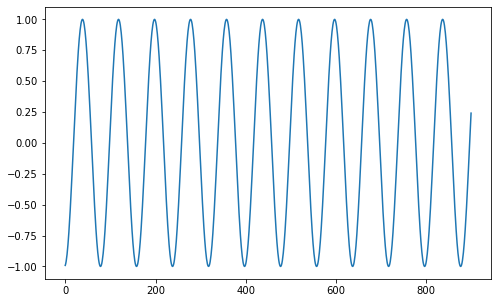

In [60]:
plt.plot(sine[600:1500])

In [61]:
Forward = PFB(sine, 1024, 4)

In [62]:
Orginal = PFB_Inverse(Forward, 4)

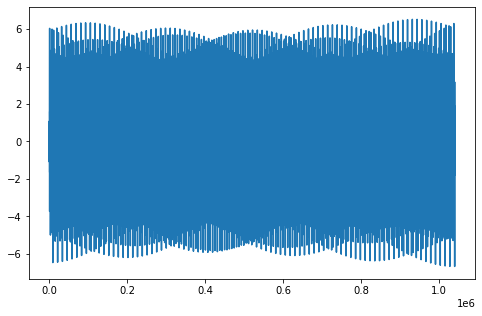

In [63]:
plt.plot(Orginal)

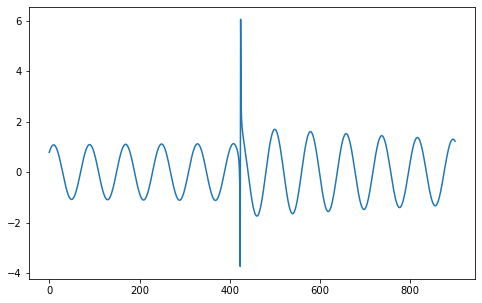

In [64]:
plt.plot(Orginal[600:1500])